# Concept Drift
---
notebooks adapted from the [streaming-data-analytics](https://github.com/emanueledellavalle/streaming-data-analytics) repo.

---

Dynamic environments are challenging for machine learning methods because data changes over time.

For this example, we will generate a synthetic data stream by concatenating data from 3 different distributions:
- $dist_a$: value from $0.0$ to $0.4$
- $dist_b$: value from $0.4$ to $0.5$
- $dist_c$: value from $0.7$ to $1.0$

In [72]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

In [73]:
import river
river.__version__

'0.21.0'

In [57]:
def plot_data(dist_a, dist_b, dist_c, drifts=None, warnings=None):
    color_0 = 'red'
    color_1 = 'green'
    color_2 = 'blue'

    plt.figure(figsize=(4, 2))
    plt.title("drift stream")
    plt.xlabel("samples")
    plt.ylabel("value")

    plt.scatter(list(range(1000)), dist_a, c=color_0, s=0.1, label="dist_A")
    plt.scatter(list(range(1000, 2000)), dist_b, c=color_1, s=0.1, label="dist_B")    
    plt.scatter(list(range(2000, 3000)), dist_c, c=color_2, s=0.1, label="dist_C") 

    if drifts is not None:
        for drift_loc in drifts:
            plt.axvline(drift_loc, c='red')
    
    if warnings is not None:
        for warning_loc in warnings:
            plt.axvline(warning_loc, c='red')

def plot_hist(dist_a, dist_b, dist_c):
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.title("A")
    plt.hist(dist_a, density=True, bins=50)

    plt.subplot(1, 3, 2)
    plt.title("B")
    plt.hist(dist_b, density=True, bins=50)

    plt.subplot(1, 3, 3)
    plt.title("C")
    plt.hist(dist_c, density=True, bins=50)
    

In [58]:
np.random.seed(42)
dist_a1 = np.random.uniform(0,0.3,750)
dist_a2 = np.random.uniform(0,0.4,250)
dist_a = np.concatenate((dist_a1, dist_a2))
dist_b = np.random.uniform(0.4,0.5,1000)
dist_c = np.random.uniform(0.7,1,1000)

data_stream = np.concatenate((dist_a, dist_b, dist_c))

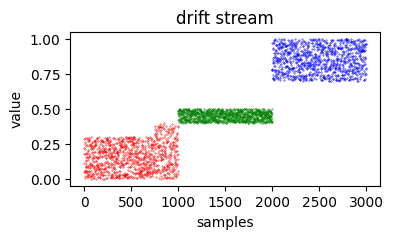

In [59]:
plot_data(dist_a, dist_b, dist_c)

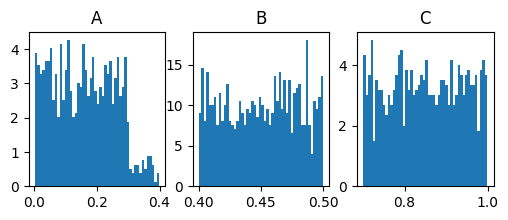

In [60]:
plot_hist(dist_a, dist_b, dist_c)

As observed above, the synthetic data stream has **1 gradual drifts** and **1 abrupt drift**.

The goal is to detect that drift has occurred, after samples **1000** and **2000** in the synthetic data stream.

## ADWIN
---
In this example, we will use the [ADaptive WINdowing (`ADWIN`)](https://riverml.xyz/latest/api/drift/ADWIN/) drift detection method.

In [61]:
from river.drift import ADWIN

drift_detector = ADWIN()
drifts = []
warnings = []
warning = -1

for i, val in enumerate(data_stream):
    drift_detector.update(val)           # Data is processed one sample at a time
    if drift_detector.drift_detected:
        print(f'Change detected at index {i}')
        drifts.append(i)

Change detected at index 1055
Change detected at index 2047


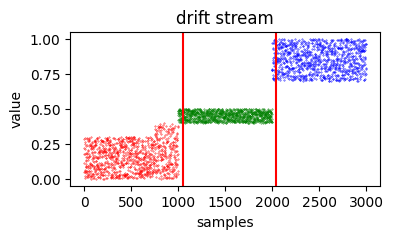

In [62]:
plot_data(dist_a,dist_b,dist_c,drifts,warnings)

## Page Hinkley
---
In this example, we will use the [Page Hinkley](https://riverml.xyz/latest/api/drift/PageHinkley/) drift detection method. This change detection method works by computing the observed values and their mean up to the current moment. Page-Hinkley does not signal warning zones, only change detections. The method works by means of the Page-Hinkley test. In general lines it will detect a concept drift if the observed mean at some instant is greater then a threshold value lambda.

In [63]:
from river.drift import PageHinkley

drift_detector = PageHinkley()
drifts = []
warnings = []
warning = -1

for i, val in enumerate(data_stream):
    drift_detector.update(val)           # Data is processed one sample at a time
    if drift_detector.drift_detected:
        print(f'Change detected at index {i}')
        drifts.append(i)

Change detected at index 1156
Change detected at index 2136


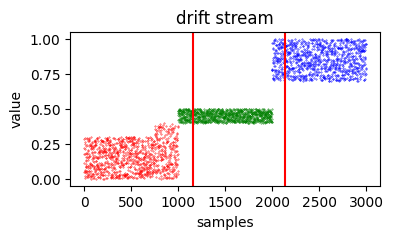

In [64]:
plot_data(dist_a,dist_b,dist_c,drifts,warnings)

## DDM
---
In this example, we will use the [DDM](https://riverml.xyz/latest/api/drift/DDM/) drift detection method. It is based on the PAC learning model premise, that the learner's error rate will decrease as the number of analysed samples increase, as long as the data distribution is stationary.

If the algorithm detects an increase in the error rate, that surpasses a calculated threshold, either change is detected or the algorithm will warn the user that change may occur in the near future, which is called the warning zone.

In [65]:
from river.drift.binary import DDM

drift_detector = DDM()
drifts = []
warnings = []
warning = -1

for i, val in enumerate(data_stream):
    drift_detector.update(val)           # Data is processed one sample at a time
    if drift_detector.drift_detected:
        print(f'Change detected at index {i}')
        drifts.append(i)

Change detected at index 1059
Change detected at index 2085


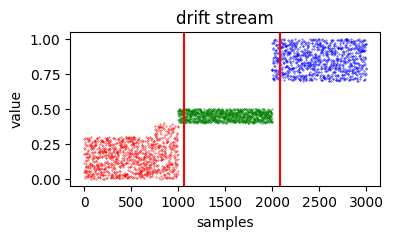

In [66]:
plot_data(dist_a,dist_b,dist_c,drifts,warnings)

## EDDM
---
In this example, we will use the [EDDM](https://riverml.xyz/latest/api/drift/EDDM/) drift detection method. It works by keeping track of the average distance between two errors instead of only the error rate. For this, it is necessary to keep track of the running average distance and the running standard deviation, as well as the maximum distance and the maximum standard deviation.

In [67]:
from river.drift.binary import EDDM

drift_detector = EDDM()
drifts = []
warnings = []
warning = -1

for i, val in enumerate(data_stream):
    drift_detector.update(val)           # Data is processed one sample at a time
    if drift_detector.drift_detected:
        print(f'Change detected at index {i}')
        drifts.append(i)

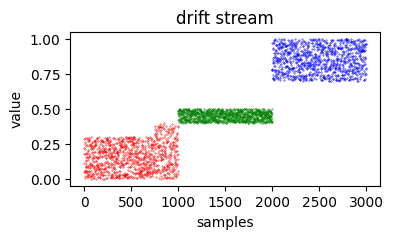

In [68]:
plot_data(dist_a,dist_b,dist_c,drifts,warnings)

## CUSUM
---
It gives an alarm when the mean of the input data is significantly different from zero.
- $g_0 = 0$
- $\hat{x}$ update
- $sum_t = max(0,sum_{t-1}+(x_t - \hat{x}) - \delta)$
- $n += 1$
- if $n > min_{obs}$ and $sum_t > \lambda:$ Change

Use $\delta=0.005$, $\lambda=50$, and $min_{obs}=30$

In [69]:
class CUSUM():
    def __init__(self,delta,lamb,min_obs):
        # Initialization
        self._n = 1
        self._x_mean = 0.0
        self._sum = 0.0
        self._delta = delta
        self._lambda = lamb
        self._min_obs = min_obs
        self.warning_detected = False
        self.change_detected = False
        
    def update(self,value):
        self._x_mean += (value - self._x_mean) / self._n
        self._sum = max(0,self._sum + value - self._x_mean - self._delta)
        self._n += 1
        
        if self._n >= self._min_obs and self._sum > self._lambda:
            self.change_detected = True
        
        
    def reset(self):
        self._n = 1
        self._x_mean = 0.0
        self._sum = 0.0
        self.warning_detected = False
        self.change_detected = False

In [70]:
drift_detector = CUSUM(delta=0.005,lamb=50,min_obs=30)
drifts = []
warnings = []
warning = -1

for i, val in enumerate(data_stream):
    drift_detector.update(val)           # Data is processed one sample at a time
    if drift_detector.warning_detected:
        warning = i
    if drift_detector.change_detected:
        if warning != -1:
            print(f'Warning detected at index {warning} and Change detected at index {i}')
            warnings.append(warning)
            warning = -1
        else: 
            print(f'Change detected at index {i}')
        drifts.append(i)
        drift_detector.reset()          # As a best practice, we reset the detector

Change detected at index 1154
Change detected at index 2135


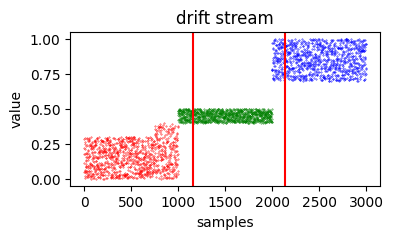

In [71]:
plot_data(dist_a,dist_b,dist_c,drifts,warnings)